> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Working with time-series of images

This notebook demonstrates how you can use time-series data with Raster Vision. We will query a STAC API for a spatiotemporal data cube and use a temporal model to run inference on it.

In particular, we will use a simple pre-trained model that computes attention scores for each image in the time-series. We will see that images with cloud cover get assigned lower attention scores.

## Install dependencies

In [ ]:
%pip install -q pystac_client

---

In [18]:
from rastervision.core.box import Box
from rastervision.core.data import (RasterioCRSTransformer, StatsTransformer,
                                    XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset)

from tqdm.auto import tqdm
import math
import torch
import pystac_client
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
BANDS = [
    'coastal',  # B01
    'blue',  # B02
    'green',  # B03
    'red',  # B04
    'rededge1',  # B05
    'rededge2',  # B06
    'rededge3',  # B07
    'nir',  # B08
    'nir08',  # B8A
    'nir09',  # B09
    'swir16',  # B11
    'swir22',  # B12
]

---

## Get a time-series of Sentinel-2 images from a STAC API

Get Sentinel-2 imagery from 2023-06-01 to 2023-06-20 over Paris, France.

In [4]:
bbox = Box(ymin=48.8155755, xmin=2.224122, ymax=48.902156, xmax=2.4697602)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [13]:
URL = 'https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-c1-l2a'],
    datetime='2023-06-01/2023-06-20',
).item_collection()
len(items)

8

### Convert to a Raster Vision `RasterSource`

In [10]:
raster_source = XarraySource.from_stac(
    items,
    bbox_map_coords=tuple(bbox),
    temporal=True,
    stackstac_args=dict(rescale=False, fill_value=0, assets=BANDS),
    allow_streaming=True,
)
raster_source.shape

(8, 947, 1810, 12)

The model expects unnormalized data, but we do need to normalize it if we want to visualize it. Below, we compute stats from the first 2 images in the sequence since they are free of clouds (this was determined by inspecting the images). We then use those stats to create a normalized version of the same `RasterSource` as above but with only the red, green, and blue bands.

In [16]:
raster_source_stats = XarraySource(
    raster_source.data_array.isel(time=[0, 1]),
    crs_transformer=raster_source.crs_transformer,
    bbox=raster_source.bbox,
    temporal=True,
)

stats_tf = StatsTransformer.from_raster_sources([raster_source_stats])

raster_source_viz = XarraySource(
    raster_source.data_array,
    channel_order=[3, 2, 1],  # RGB
    crs_transformer=raster_source.crs_transformer,
    raster_transformers=[stats_tf],
    bbox=raster_source.bbox,
    temporal=True,
)
raster_source_viz.shape

Analyzing chips: 0it [00:00, ?it/s]

(8, 947, 1810, 3)

Visualize the images in the time-series:

  0%|          | 0/8 [00:00<?, ?it/s]

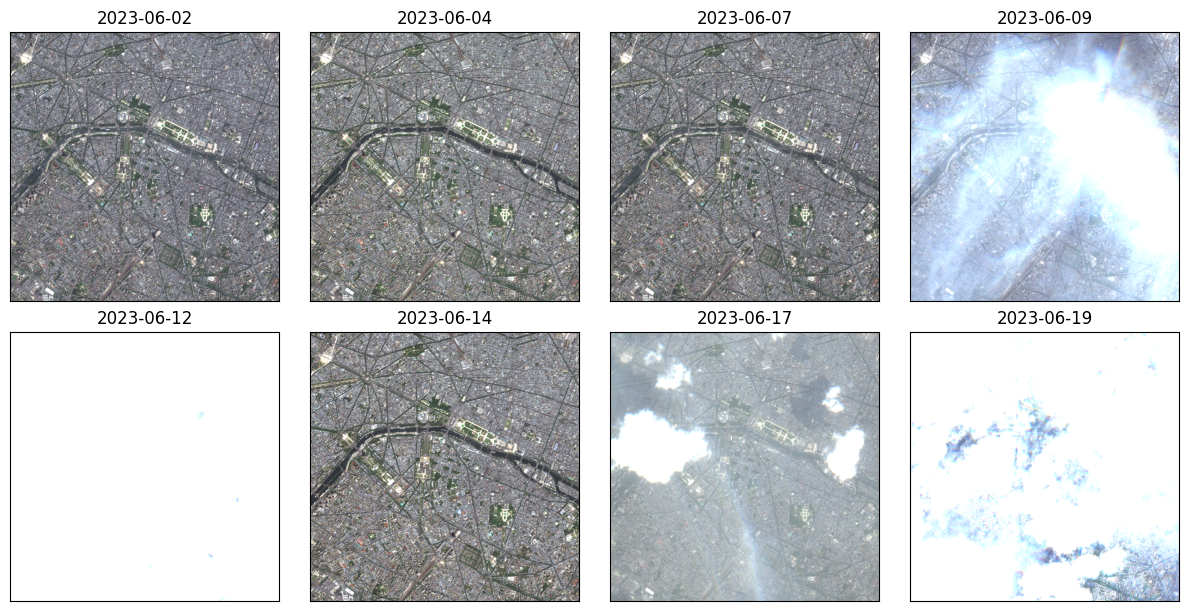

In [19]:
T = raster_source_viz.shape[0]
dates = [str(s.date()) for s in raster_source_viz.data_array.time.to_series()]

ncols = 4
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
with tqdm(zip(range(T), dates, axs.flat), total=T) as bar:
    for t, date, ax in bar:
        chip = raster_source_viz[t, 200:800, 400:1000]
        ax.imshow(chip)
        ax.set_title(date, fontsize=12)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
plt.show()

---

## Get model

We will use a model from a fork of https://github.com/jamesmcclain/geospatial-time-series.

In [20]:
model_weights_path = 'https://s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/tutorials-data/temporal/pretrained-resnet18-weights.pth'

In [ ]:
model = torch.hub.load(
    'AdeelH/geospatial-time-series:rv-demo',
    'SeriesResNet18',
    source='github',
    trust_repo=False,
)
model.load_state_dict(torch.hub.load_state_dict_from_url(model_weights_path))
model = model.to(device=DEVICE)
model = model.eval()

---

## Run inference

Create a `RandomWindowGeoDataset` from the temporal `RasterSource`.

In [23]:
scene = Scene(id='test_scene', raster_source=raster_source)
ds = SemanticSegmentationRandomWindowGeoDataset(
    scene=scene, size_lims=(256, 256 + 1), out_size=256, max_windows=10, return_window=True)

Sample a (temporal) chip:

In [24]:
(x, _), window = ds[0]
x.shape

torch.Size([8, 12, 256, 256])

Get attention scores for each image in the series:

In [25]:
with torch.inference_mode():
    _x = x.unsqueeze(0).to(device=DEVICE)
    embeddings = model.forward_embeddings(_x)
    attention = model.embeddings_to_attention(embeddings)
    attention = attention.squeeze(-1)
attention.shape

torch.Size([1, 8])

### Visualize model outputs

We can see that the model assigns lower scores to images with cloud cover, which makes intuitive sense.

For visualization, sample the same chip from the normalized `RasterSource`.

In [26]:
x_viz = raster_source_viz.get_chip(window)
x_viz.shape

(8, 256, 256, 3)

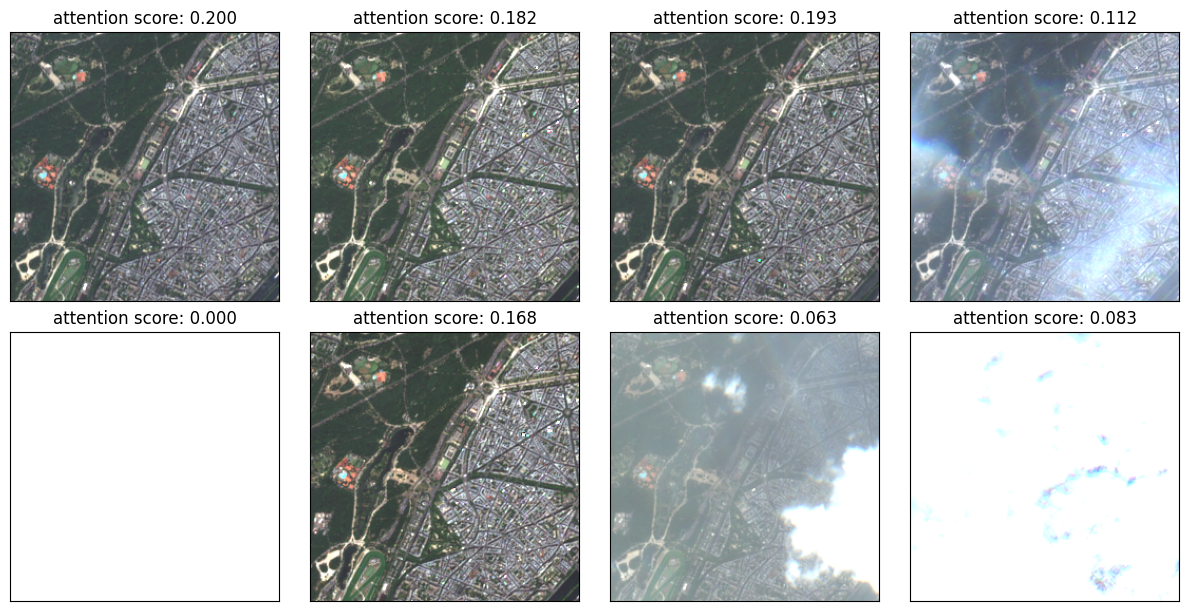

In [29]:
T = x_viz.shape[0]
ncols = 4
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
for ax, x_viz_t, attn_t in zip(axs.flat, x_viz, attention[0]):
    ax.imshow(x_viz_t)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
    ax.set_title(f'attention score: {attn_t:.3f}')
plt.show()